In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
#print(test_images.shape)

C:\Users\ytw\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ytw\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\ytw\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


(2811, 244, 244, 3) (2811, 42, 2)


Data pre-process

In [2]:
#grayscale the image first
gray_images=np.zeros(images.shape[:-1])
for i in range(images.shape[0]):
  gray_images[i]=np.uint8(np.mean(images[i],axis=-1))

#smaller the image
sma_img=np.zeros((2811,61,61))
for i in range(2811):
  sma_img[i] = cv2.resize(gray_images[i], (61 , 61), interpolation=cv2.INTER_AREA)

#smaller the points
sma_pts=np.zeros((2811,42,2))
for i in range(2811):
  sma_pts[i][:,0]=pts[i][:,0]//4
  sma_pts[i][:,1]=pts[i][:,1]//4

#flatten the pts into 1d
fla_pts=np.zeros((2811,84))
for i in range(sma_pts.shape[0]):
  fla_pts[i]=sma_pts[i].flatten()

#split the training set and validation set
valid_images=sma_img[-500:]
valid_pts=fla_pts[-500:]
train_images=sma_img[:-500]
train_pts=fla_pts[:-500]
print(len(train_images))

2311


822


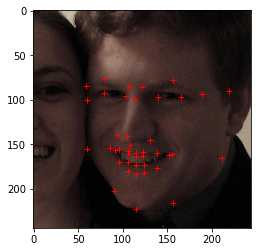

In [5]:
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(1):
    idx = np.random.randint(0, images.shape[0])
    print(idx)
    visualise_pts(images[idx, ], pts[idx, ])

Try to use CNN

In [8]:
import tensorflow as tf
keras = tf.keras
layers = tf.keras.layers
# Include numpy for basic stuff
import numpy as np
# matplotlib allows us to visualise our data.
import matplotlib.pyplot as plt
# Import a library for displaying models
from IPython.display import Image

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_pts))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_pts))
val_dataset = val_dataset.batch(64)

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from math import sin, cos, pi

from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, LeakyReLU, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential

In [14]:
model = Sequential()
pretrained_model = ResNet50(input_shape=(61,61,3), include_top=False, weights='imagenet')
pretrained_model.trainable = True


model.add(Conv2D(3, (3,3), padding='same', input_shape=(61,61,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1)) #avoid overfitting
model.add(Dense(84))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 61, 61, 3)         30        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 61, 61, 3)         0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 84)                172116    
                                                      

In [1]:
%%time

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlyStopping = EarlyStopping(monitor='loss', patience=30, mode='min',baseline=None)   #when the accuracy on validation set stop imporving, stop the training

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)  #Reduce learning rate when a metric has stopped improving

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

history = model.fit(train_images, train_pts, epochs=30, batch_size=64, validation_data=val_dataset, callbacks=[earlyStopping, rlp])

KeyboardInterrupt: 

Text(0.5, 0.98, 'Model Metrics')

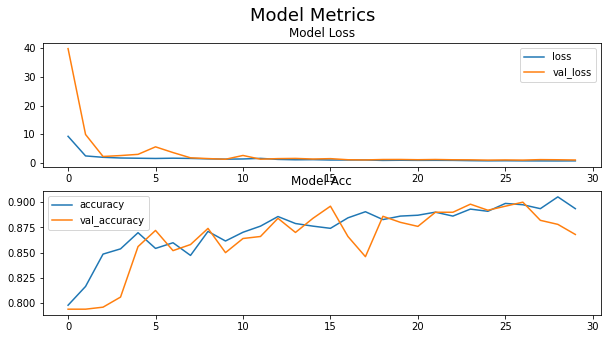

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
df = pd.DataFrame(history.history)
df[['loss', 'val_loss']].plot(ax=ax[0])
df[['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].set_title('Model Loss', fontsize=12)
ax[1].set_title('Model Acc', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18)

In [ ]:
#try to find the error 

def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
train_preds = model.predict(train_images)

dis=euclid_dist(train_preds,train_pts)


In [ ]:
np.average(dis)

0.7245485094930769

In [ ]:
#before the prediction, need to pre process the testing set as well
#grayscale the image first
gray_img_test=np.zeros(test_images.shape[:-1])
for i in range(test_images.shape[0]):
  gray_img_test[i]=np.uint8(np.mean(test_images[i],axis=-1))

#smaller the image
sma_img_test=np.zeros((554,61,61))
for i in range(554):
  sma_img_test[i] = cv2.resize(gray_img_test[i], (61 , 61), interpolation=cv2.INTER_AREA)

In [ ]:
#prediction
test_preds = model.predict(sma_img_test)

In [ ]:
#need to unflatten the pts
unfla_pts=np.zeros((554,42,2))
for i in range(554):
    unfla_pts[i]=test_preds[i].reshape(42,2)

#make the points back to original size
test_pts=np.zeros((554,42,2))
for i in range(554):
    test_pts[i][:,0]=unfla_pts[i][:,0]*4
    test_pts[i][:,1]=unfla_pts[i][:,1]*4


6


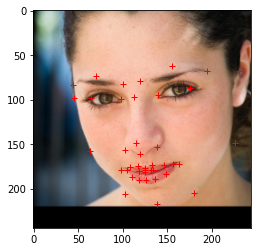

318


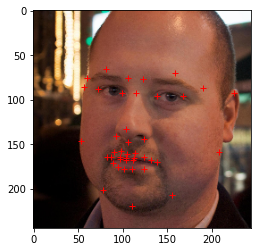

400


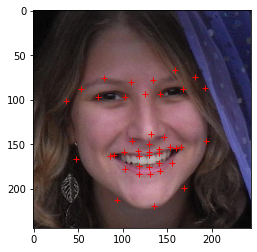

In [ ]:
#visualization
for i in range(3):
    idx = np.random.randint(0, test_images.shape[0])
    print(idx)
    visualise_pts(test_images[idx, ], test_pts[idx, ])

In [ ]:
#download the result
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

save_as_csv(test_pts,location='.')

Try to augment the image, if the accuracy changed

Rotate the imagee

749


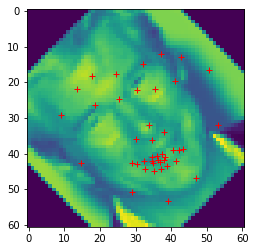

356


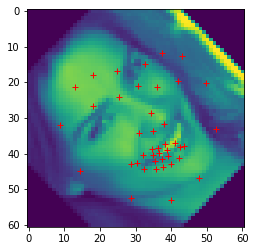

1594


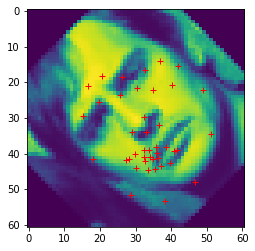

In [ ]:
import imutils

train_img_rotate=np.zeros(train_images.shape)
for i in range(2311):
  train_img_rotate[i]=imutils.rotate(train_images[i], angle=45)

#prediction
test1 = model.predict(train_img_rotate)

#need to unflatten the pts
unfla_pts=np.zeros((2311,42,2))
for i in range(2311):
    unfla_pts[i]=test1[i].reshape(42,2)


#visualization
for i in range(3):
    idx = np.random.randint(0, train_img_rotate.shape[0])
    print(idx)
    visualise_pts(train_img_rotate[idx, ], unfla_pts[idx, ])

In [3]:
from numpy import genfromtxt
test_pts = genfromtxt('results.csv', delimiter=',')
test_pts=test_pts.reshape(554,42,2)

497


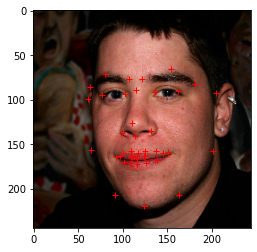

27


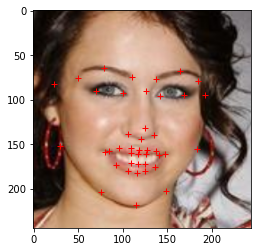

352


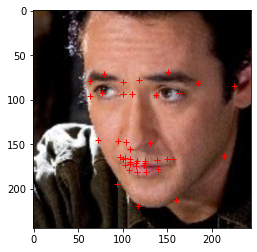

In [6]:
for i in range(3):
    idx = np.random.randint(0, test_images.shape[0])
    print(idx)
    visualise_pts(test_images[idx, ], test_pts[idx, ])

Change the color of lips

In [7]:
def lips_color(idx):
    #initialization
    img=test_images[idx]
    lipsPoints = test_pts[idx][-20:]  #last 20 points are for lips
    
    #make a mask with the shape of image
    mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.float32)
    #draw ConvexPoly
    cv2.fillConvexPoly(mask, np.int32(lipsPoints), (30,30,30))
    mask = 255*np.uint8(mask)
    #apply closing operation to lips, it can make lips more complete
    kernel = np.ones((15,15),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  
    #apply blur, make edge of lips look natural
    mask = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)
    #Calculate inverse mask
    inverseMask = cv2.bitwise_not(mask)
    #Convert masks to float to perform blending
    mask = mask.astype(float)/255
    inverseMask = inverseMask.astype(float)/255
    #apply color to the lips
    lips = cv2.applyColorMap(img, cv2.COLORMAP_DEEPGREEN)
    #Convert lips and face to 0-1 range
    lips = lips.astype(float)/255
    Face = img.astype(float)/255
    #Multiply lips and face by the masks
    justLips = cv2.multiply(mask, lips)
    justFace = cv2.multiply(inverseMask, Face)
    #add them together
    result = justFace + justLips
    return result

263


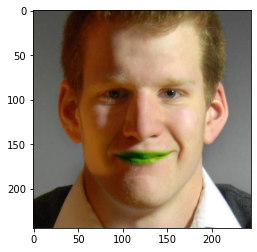

213


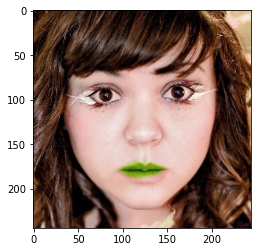

551


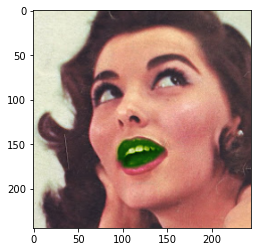

In [13]:
for i in range(3):
    idx = np.random.randint(0, test_images.shape[0])
    print(idx)
    plt.imshow(lips_color(idx))
    plt.show()